---
title: "Orientation"
---

## Setup

In [1]:
#| hide
import polars as pl
from ids_finder.utils.basic import load_catalog

from beforerr.r import py2rpy_polars
import rpy2.robjects as robjects

from ids_finder.pipelines.project.pipeline import process_events_l2
from ids_finder.utils.polars import pl_norm

import hvplot.polars
import warnings

# Suppress specific FutureWarning from pandas in Holoviews
warnings.filterwarnings(
    "ignore", category=FutureWarning, module="holoviews.core.data.pandas"
)


In [2]:
#| hide
%load_ext autoreload
%autoreload 2
%load_ext rpy2.ipython

catalog = load_catalog()

r = robjects.r
r.source('utils.R')
conv_pl = py2rpy_polars()

[11/30/23 09:11:00] WARNING  KedroDeprecationWarning: 'AbstractVersionedDataSet' has been renamed to  ]8;id=433014;file:///Users/zijin/miniforge3/envs/cool_planet/lib/python3.10/site-packages/astropy/logger.py\logger.py]8;;\:]8;id=162189;file:///Users/zijin/miniforge3/envs/cool_planet/lib/python3.10/site-packages/astropy/logger.py#205\205]8;;\
                             'AbstractVersionedDataset', and the alias will be removed in Kedro                    
                             0.19.0                                                                                
                                                                                                                   

                    WARNING  R[write to console]:                                                  ]8;id=494012;file:///Users/zijin/miniforge3/envs/cool_planet/lib/python3.10/site-packages/rpy2/rinterface_lib/callbacks.py\callbacks.py]8;;\:]8;id=716384;file:///Users/zijin/miniforge3/envs/cool_planet/lib/python3.10/site-packages/rpy2/rinterface_lib/callbacks.py#124\124]8;;\
                             Attaching package: ‘dplyr’                                                            
                                                                                                                   
                                                                                                                   

                    WARNING  R[write to console]: The following objects are masked from            ]8;id=455067;file:///Users/zijin/miniforge3/envs/cool_planet/lib/python3.10/site-packages/rpy2/rinterface_lib/callbacks.py\callbacks.py]8;;\:]8;id=513694;file:///Users/zijin/miniforge3/envs/cool_planet/lib/python3.10/site-packages/rpy2/rinterface_lib/callbacks.py#124\124]8;;\
                             ‘package:stats’:                                                                      
                                                                                                                   
                                 filter, lag                                                                       
                                                                                                                   
                                                                                                                   

                    WARNING  R[write to console]: The following objects are masked from            ]8;id=32710;file:///Users/zijin/miniforge3/envs/cool_planet/lib/python3.10/site-packages/rpy2/rinterface_lib/callbacks.py\callbacks.py]8;;\:]8;id=30824;file:///Users/zijin/miniforge3/envs/cool_planet/lib/python3.10/site-packages/rpy2/rinterface_lib/callbacks.py#124\124]8;;\
                             ‘package:base’:                                                                       
                                                                                                                   
                                 intersect, setdiff, setequal, union                                               
                                                                                                                   
                                                                                                                   

In [29]:
all_events_l1: pl.DataFrame = catalog.load("events.l1.ALL_sw_ts_1s_tau_60s").collect()
JNO_events_l1 = all_events_l1.filter(pl.col("sat") == "JNO")
other_events_l1 = all_events_l1.filter(pl.col("sat") != "JNO")
all_events_l2 = all_events_l1.pipe(process_events_l2)

cols = ["dB_x_norm", "dB_y_norm", "dB_z_norm"]

all_events_l1 = (
    all_events_l1.with_columns(dB=pl_norm(cols))
    .with_columns(
        dB_x_n2=pl.col("dB_x_norm") / pl.col("dB"),
        dB_y_n2=pl.col("dB_y_norm") / pl.col("dB"),
        dB_z_n2=pl.col("dB_z_norm") / pl.col("dB"),
    )
    .with_columns(
        theta_dB=pl.col("dB_z_n2").arccos().degrees(),
        phi_dB=(pl.col("dB_y_n2") / pl.col("dB_x_n2")).arctan().degrees(),
    )
)

[11/30/23 09:39:18] INFO     Loading data from 'events.l1.ALL_sw_ts_1s_tau_60s'                 ]8;id=813001;file:///Users/zijin/miniforge3/envs/cool_planet/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=7617;file:///Users/zijin/miniforge3/envs/cool_planet/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (LazyPolarsDataset)...                                                                

In [5]:
%R -i JNO_events_l1 -c conv_pl
%R -i all_events_l1 -c conv_pl
%R -i other_events_l1 -c conv_pl
%R -i all_events_l2 -c conv_pl

## $\theta_{n,b}$

In [4]:
all_events_l1['theta_n_b'].describe()

statistic,value
str,f64
"""count""",280740.0
"""null_count""",0.0
"""mean""",89.565227
"""std""",24.914059
"""min""",0.046898
"""25%""",78.403561
"""50%""",89.87696
"""75%""",100.96636
"""max""",179.86788


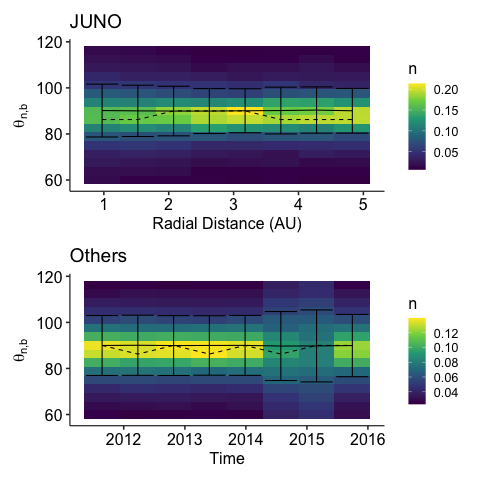

In [5]:
%%R
y <- "theta_n_b"
ylab <- expression(theta["n,b"])
y_lim <- c(60, 120)
p1 <- plot_dist(y=y, ylab=ylab, y_lim = y_lim, y_log=FALSE)
p1

## Change of magnetic field

In [21]:
%%R

probs <- c(0.99, 0.9, 0.7, 0.5, 0.3, 0.1)

plot_plot <- function(df, x, y, type = "hdr") {
  p <- ggplot(all_events_l1, aes(x = .data[[x]], y = .data[[y]]) ) +
    facet_wrap(vars(sat)) +
    scale_color_okabeito(palette = "black_first")

  if (type == "hdr") {
    p <- p + geom_hdr_lines(
      aes(color=sat),
      probs = probs
    )
  } else if (type == "density") {
    p <- p + geom_density_2d_filled()
  }

  return (p)
}

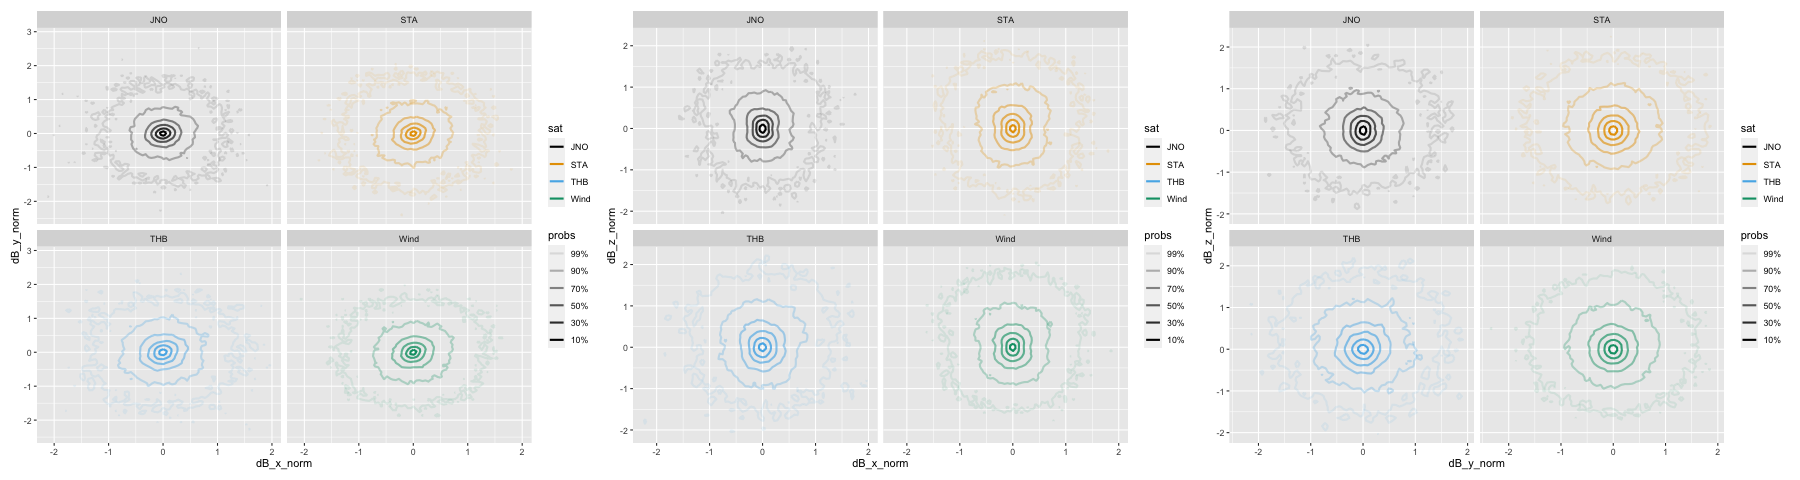

In [24]:
%%R -w 1800

x <- "dB_x_norm"
y <- "dB_y_norm"
z <- "dB_z_norm"

p1 <- plot_plot(all_events_l1, x, y)
p2 <- plot_plot(all_events_l1, x, z)
p3 <- plot_plot(all_events_l1, y, z)

p1 | p2 | p3

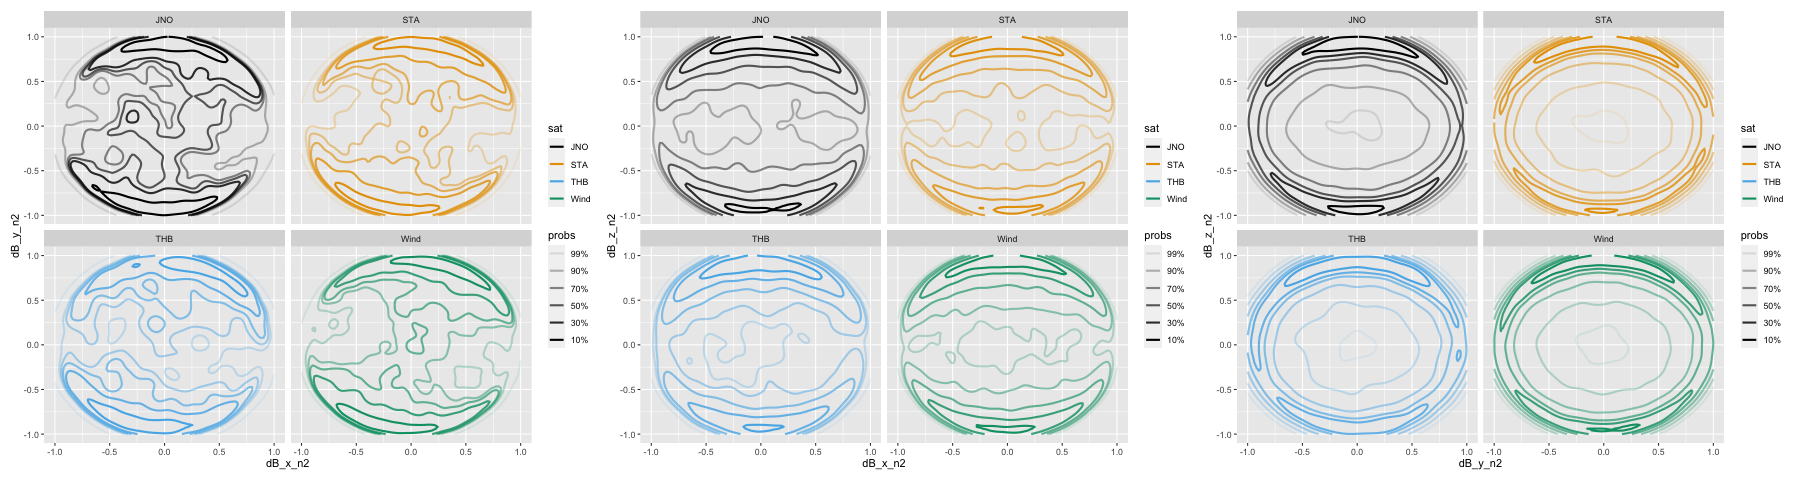

In [22]:
%%R -w 1800
probs <- c(0.99, 0.9, 0.7, 0.5, 0.3, 0.1)

x <- "dB_x_n2"
y <- "dB_y_n2"
z <- "dB_z_n2"

p1 <- plot_plot(all_events_l1, x, y)
p2 <- plot_plot(all_events_l1, x, z)
p3 <- plot_plot(all_events_l1, y, z)

p1 | p2 | p3

In [42]:
(all_events_l1.hvplot.hist('theta_dB', by="sat",subplots=True).cols(1) + all_events_l1.hvplot.hist('phi_dB', by="sat",subplots=True).cols(1))

:Layout
   .NdLayout.I  :NdLayout   [sat]
      :Histogram   [theta_dB]   (theta_dB_count)
   .NdLayout.II :NdLayout   [sat]
      :Histogram   [phi_dB]   (phi_dB_count)

In [23]:
hvplot.scatter_matrix(all_events_l1.select(cols).to_pandas(), chart = 'hexbin')

[11/30/23 08:51:41] WARNING  /Users/zijin/miniforge3/envs/cool_planet/lib/python3.10/site-packages/ho ]8;id=909891;file:///Users/zijin/miniforge3/envs/cool_planet/lib/python3.10/site-packages/astropy/logger.py\logger.py]8;;\:]8;id=98174;file:///Users/zijin/miniforge3/envs/cool_planet/lib/python3.10/site-packages/astropy/logger.py#205\205]8;;\
                             loviews/core/util.py:1891: FutureWarning: Creating a Groupby object with              
                             a length-1 list-like level parameter will yield indexes as tuples in a                
                             future version. To keep indexes as scalars, create Groupby objects with               
                             a scalar level parameter instead.                                                     
                               groups = ((wrap_tuple(k), group_type(OrderedDict(unpack_group(group,                
                             getter)), **kwargs))                                                                  
                                                                                                                   

                    WARNING  /Users/zijin/miniforge3/envs/cool_planet/lib/python3.10/site-packages/ho ]8;id=377918;file:///Users/zijin/miniforge3/envs/cool_planet/lib/python3.10/site-packages/astropy/logger.py\logger.py]8;;\:]8;id=564198;file:///Users/zijin/miniforge3/envs/cool_planet/lib/python3.10/site-packages/astropy/logger.py#205\205]8;;\
                             loviews/core/util.py:1891: FutureWarning: Creating a Groupby object with              
                             a length-1 list-like level parameter will yield indexes as tuples in a                
                             future version. To keep indexes as scalars, create Groupby objects with               
                             a scalar level parameter instead.                                                     
                               groups = ((wrap_tuple(k), group_type(OrderedDict(unpack_group(group,                
                             getter)), **kwargs))                                                                  
                                                                                                                   

:GridMatrix   [X,Y]
   :Histogram   [dB_z_norm]   (dB_z_norm_count)

## Normal direction obtained from dot product

In [11]:
def dist_plot(df: pl.LazyFrame, var, by="sat"):
    return df.hvplot.density(var, by=by, subplots=True, width=300, height=300).cols(1)

In [12]:
(dist_plot(all_events_l1, "k_x") + dist_plot(all_events_l1, "k_y") + dist_plot(all_events_l1, "k_z")).cols(3)

:Layout
   .NdLayout.I   :NdLayout   [sat]
      :Distribution   [k_x]   (Density)
   .NdLayout.II  :NdLayout   [sat]
      :Distribution   [k_y]   (Density)
   .NdLayout.III :NdLayout   [sat]
      :Distribution   [k_z]   (Density)

In [ ]:
# all_events_l1.hvplot.scatter("k_x", "k_y", by="sat", subplots=True, width=300, height=300,  datashade=True)
# all_events_l1.hvplot.bivariate("k_x", "k_y", by="sat", subplots=True, width=600, height=500) # bug: `by` not working

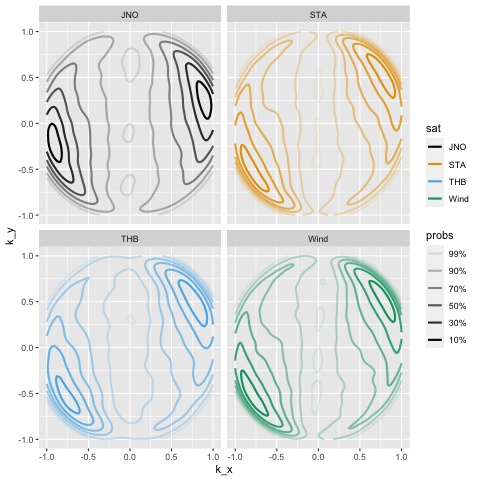

In [9]:
%%R
probs <- c(0.99, 0.9, 0.7, 0.5, 0.3, 0.1)
ggplot(all_events_l1, aes(x=k_x, y=k_y, color=sat) ) +
  geom_hdr_lines(probs = probs) +
  facet_wrap(vars(sat)) +
  scale_color_okabeito(palette = "black_first")

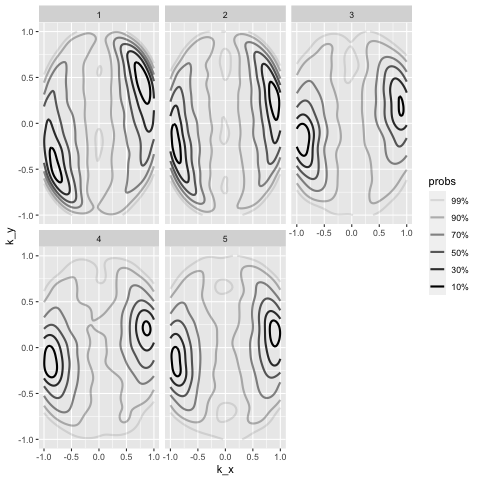

In [ ]:
%%R
ggplot(JNO_events_l1, aes(x=k_x, y=k_y) ) +
  geom_hdr_lines(probs = probs) +
  facet_wrap(vars(r_bin))

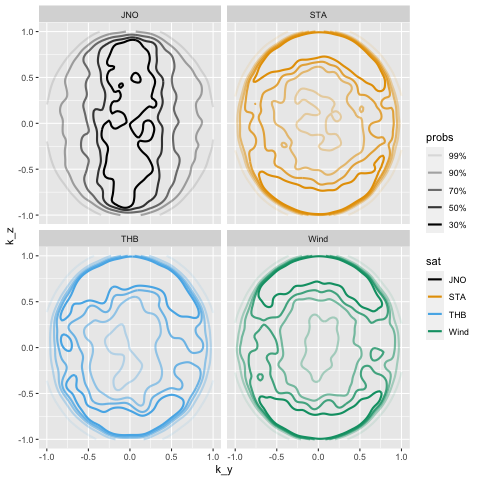

In [ ]:
%%R
probs <- c(0.99, 0.9, 0.7, 0.5, 0.3)
ggplot(all_events_l1, aes(x=k_y, y=k_z, color=sat) ) +
  geom_hdr_lines(probs = probs) +
  facet_wrap(vars(sat)) +
  scale_color_okabeito(palette = "black_first")

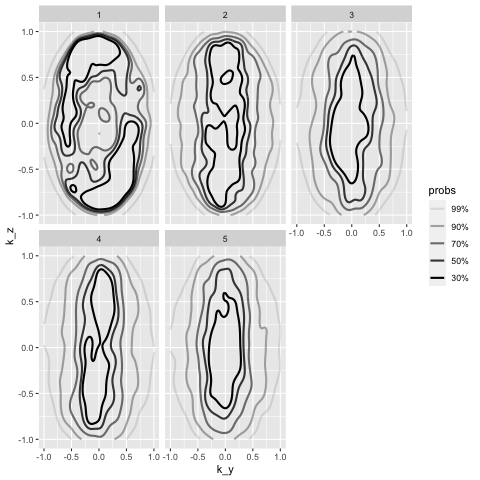

In [ ]:
%%R
probs <- c(0.99, 0.9, 0.7, 0.5, 0.3)
ggplot(JNO_events_l1, aes(x=k_y, y=k_z) ) +
  geom_hdr_lines(probs = probs) +
  facet_wrap(vars(r_bin)) +
  scale_color_okabeito(palette = "black_first")

### $V_l$

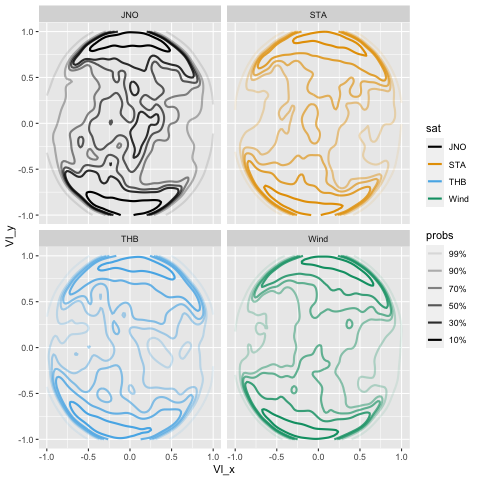

In [ ]:
%%R
probs <- c(0.99, 0.9, 0.7, 0.5, 0.3, 0.1)
ggplot(all_events_l1, aes(x=Vl_x, y=Vl_y, color=sat) ) +
  geom_hdr_lines(probs = probs) +
  facet_wrap(vars(sat)) +
  scale_color_okabeito(palette = "black_first")

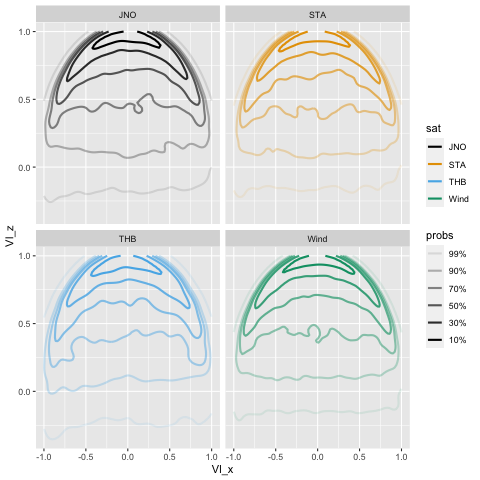

In [24]:
%%R
probs <- c(0.99, 0.9, 0.7, 0.5, 0.3, 0.1)
ggplot(all_events_l1, aes(x=Vl_x, y=Vl_z, color=sat) ) +
  geom_hdr_lines(probs = probs) +
  facet_wrap(vars(sat)) +
  scale_color_okabeito(palette = "black_first")

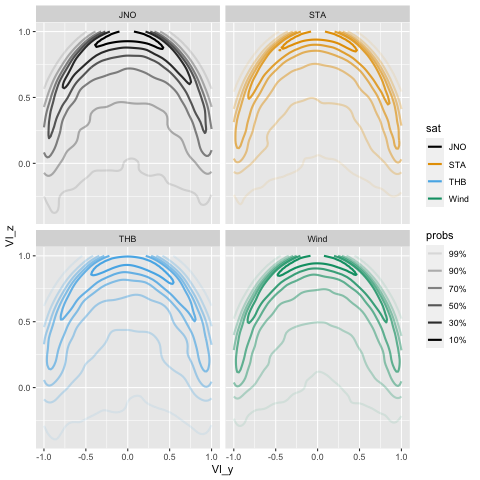

In [ ]:
%%R
probs <- c(0.99, 0.9, 0.7, 0.5, 0.3, 0.1)
ggplot(all_events_l1, aes(x=Vl_y, y=Vl_z, color=sat) ) +
  geom_hdr_lines(probs = probs) +
  facet_wrap(vars(sat)) +
  scale_color_okabeito(palette = "black_first")

### Evolution

In [ ]:
%%R
x_var <- "time"
y_vars <- c("k_x", "k_y", "k_z")
xlab <- "Time"
ylabs <- c("Orientation (k_x)", "k_y", "k_z")
p <- plot_util(all_events_l2, x_var = x_var, y_vars = y_vars, xlab=xlab, ylabs=ylabs)
save_plot("orientation/orientation_k_time")

x_var <- "ref_radial_distance"
xlab <- "Referred Radial Distance (AU)"
p <- plot_util(all_events_l2, x_var=x_var, y_vars = y_vars, xlab=xlab, ylabs=ylabs)
save_plot("orientation/orientation_k_r")

x_var <- "ref_radial_distance"
y_vars <- c("Vl_x", "Vl_y", "Vl_z")
xlab <- "Referred Radial Distance (AU)"
ylabs <- c("Orientation (l_x)", "l_y", "l_z")
p <- plot_util(all_events_l2, x_var=x_var, y_vars = y_vars, xlab=xlab, ylabs=ylabs)
save_plot("orientation/orientation_l_r")

Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image


In addition: There were 30 warnings (use warnings() to see them)


In [ ]:
%%R
x_col <- "radial_distance"
y_col <- "k_x"
y_lim <- NULL
x_bins <- 16
y_bins <- 32
xlab <- "Radial Distance (AU)"
ylab <- "Orientation (k_x)"
p <- plot_binned_data(JNO_events_l1, x_col = x_col, y_col = y_col, x_bins = x_bins, y_bins=y_bins, y_lim = y_lim, log_y = FALSE)
p <- p + labs(x = xlab, y= ylab)
save_plot("orientation/orientation_kx_r_dist")

Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
